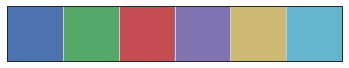

In [1]:
import sys
import sympy as sy
from sympy.abc import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as mtick
from matplotlib.mlab import griddata
import matplotlib.colors as colors
import mpmath as mp
import seaborn as sbn
sbn.set(font_scale = 2.0)
import scipy as sci
import scipy.special as special
import scipy.constants as const
import scipy.optimize as optimize
from scipy.interpolate import interp1d
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rc('font', family='DejaVu Sans')
#mpl.rc('font', weight='bold')
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
#Customizations
import matplotlib as mpl
# mpl.rcParams['font.size'] = 16
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']
# for Palatino and other serif fonts use:
# rc('font',**{'family':'serif','serif':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage[version=4]{mhchem}',# chemical reactions
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
] 
sy.init_printing()
from IPython.display import display, Math, Latex
import itertools as itt
current_palette = sbn.color_palette()
#sbn.set_style('darkgrid', {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
# sbn.set_style("whitegrid", {'axes.grid' : False})
sbn.set_style("whitegrid", {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
#sbn.palplot(current_palette = sbn.color_palette())
sbn.palplot(current_palette)
plt.show()


## Constants

In [2]:
Temperature = 300.0# Particle temperature in Kelvin
KT = const.Boltzmann*Temperature
rho = 2.33*(1e-3/1e-6)# g/cm3 -> Kg/m3
pi = const.pi
eps0 = const.epsilon_0
echarge = const.elementary_charge
Ke = 1.0/(4.0*pi*eps0)
Epsilon = 11.68

## Potentials

In [3]:
def potential_ipa_fact(rt, r21, q21, eps=Epsilon):
    """ returns Potential Drain and Sutin (Point Charge Approximation) superposition
        function of rt = r/r1, r1, q1, r21=r2/r1, q21=q2/q1
    """

    kappa = (eps-1.0)/(eps+2.0)
    A = kappa*r21**3
    B = kappa*q21**2
    return q21/rt\
           - A/(2*rt**2*(rt**2 - r21**2))\
           - B/(2*rt**2*(rt**2 - 1.0))

def force_ipa_fact(rt, r21, q21, eps=Epsilon):
    """ returns Force Drain and Sutin (Point Charge Approximation) superposition
    """

    kappa = (eps-1.0)/(eps+2.0)
    A = kappa*r21**3*(2.*rt**2-r21**2)
    B = kappa*q21**2*(2.*rt**2-1.)
    return q21/rt**2\
           - A/(rt**3*(rt**2 - r21**2)**2)\
           - B/(rt**3*(rt**2 - 1.0)**2)

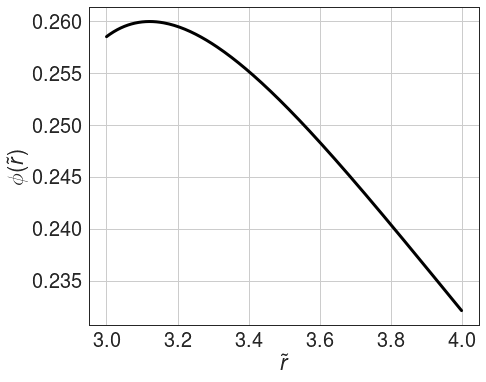

In [4]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r21 = 2.0
q21 = 1.0
rtarray = np.linspace(1.0+r21, 4.0, 200)
ax.set(xlabel=r'$\tilde{r}$', ylabel=r'$\phi(\tilde{r})$')
#plt.xlim([2.0, 10.0])
#plt.ylim([2.0, 10.0])
plt.plot(rtarray, potential_ipa_fact(rtarray, r21, q21), 'k', label=r'$\tilde{r}$', lw=3)
# ax.annotate(r'$\tilde{r}_\text{min}$', xy=(4.6, 4.6), xytext=(3, 6),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=1),
#              )
# legend=plt.legend(loc=4, frameon=True)
# legend.get_frame().set_facecolor('w')
plt.show()

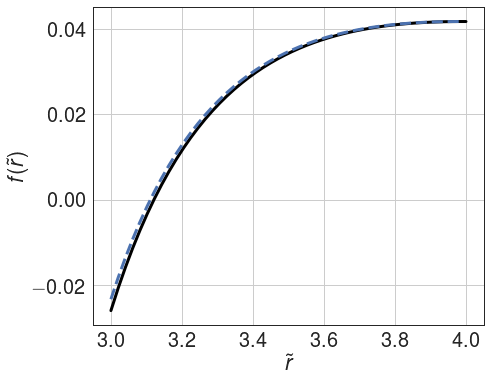

In [5]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r21 = 2.0
q21 = 1.0
rtarray = np.linspace(1.0+r21, 4.0)
ax.set(xlabel=r'$\tilde{r}$', ylabel=r'$f(\tilde{r})$')
#plt.xlim([2.0, 10.0])
#plt.ylim([2.0, 10.0])
plt.plot(rtarray, force_ipa_fact(rtarray, r21, q21), 'k', label=r'$\tilde{r}$', lw=3)
pot = potential_ipa_fact(rtarray, r21, q21)
force = -(np.diff(pot)/np.diff(rtarray))
plt.plot(rtarray[:-1], force, '--', label=r'$\tilde{r}$', lw=3)
# ax.annotate(r'$\tilde{r}_\text{min}$', xy=(4.6, 4.6), xytext=(3, 6),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=1),
#              )
# legend=plt.legend(loc=4, frameon=True)
# legend.get_frame().set_facecolor('w')
# plt.yscale('symlog')
plt.show()

In [6]:
def compute_Acoefficients(r1, q1, r2, q2, rn, eps=Epsilon, j1max=5, j2max=5):
    ''' Solves the linear system for A coefficients
    '''
    j1n = np.arange(1, j1max)
    j2n = np.arange(1, j2max)
    j3n = np.arange(0, j1max)
    # A10 term, always positive. l=0
    A10 = Ke*q1
    #
    coefficients = np.zeros((len(j1n), len(j1n)))
    independent = np.zeros((len(j1n)))
    #
    count = 0
    for j1 in j1n:# from 1 to j1max
        #
        prefac1 = (eps-1.0)*j1/((eps+1.0)*j1 + 1.0)
        # term due to Q2, j1!=0, always negative
        f2 = -prefac1*r1**(2*j1+1)*Ke*q2/rn**(j1+1)
        # this term is independent of coefficients A
        independent[j1-1] = f2
        for j3 in j3n:# from 0 to j1max
            for j2 in j2n:# from 1 to j2max
                #print(j1,j2,j3)
                count +=1
                prefac2 = (eps-1.0)*j2/((eps+1.0)*j2 + 1.0)
                denom = (np.math.factorial(j1)*np.math.factorial(j2)*np.math.factorial(j2)*np.math.factorial(j3))*rn**(j1+2*j2+j3+2)
                numer = prefac1 * prefac2 * np.math.factorial(j1+j2)*np.math.factorial(j2+j3) * r1**(2*j1+1) * r2**(2*j2+1)
                if True:#np.abs(denom) > 1.0e-200 and np.abs(numer) < 1.0e200:
                    if j3!=0:
                        coefficients[j1-1][j3-1] -= numer / denom
                    else:# j3 == 0 => A10
                        independent[j1-1] += A10*numer / denom
            if j3==j1:
                coefficients[j1-1][j3-1] += 1.0
    #print(count)
    return coefficients, independent, A10

In [7]:
def force_bichoutskaia2010(r1, q1, r2, q2, h, acoeffs, eps=Epsilon, f1=1.0, f2=1.0, f3=1.0):
    ''' As defined in equation 29 of 
        Bichoutskaia, Elena et al.
        Electrostatic analysis of the interactions between charged particles of dielectric materials.
        The Journal of Chemical Physics 133, 024105 (2010).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    force_coul = Ke*q1*q2/h**2# Coulomb term
    #
    force_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*(m+1)*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+3)
            force_2 += numer / denom

    force_2 *= -q1

    force_3 = 0.0
    for l in lns[1:-1]:# l:1 -> lns-1
        numer = (acoeffs[l]*acoeffs[l+1])*((eps+1.0)*(l)+1)#2010
        denom = (eps-1.0)*r1**(2*l+3)        
        force_3 += numer / denom

    force_3 *= -invK

    return f1*force_coul + f2*force_2 + f3*force_3

In [8]:
def force_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=Epsilon, f1=1.0, f2=1.0, f3=1.0):
    ''' As defined in equation 9 of 
        Lindgren, E. B., Chan, H.-K., Stace, A. J. & Besley, E.
        Progress in the theory of electrostatic interactions between charged particles.
        Phys. Chem. Chem. Phys. 18, 5883–5895 (2016).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    force_coul = Ke*q1*q2/h**2# Coulomb term
    #
    force_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*(m+1)*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+3)
            force_2 += numer / denom

    force_2 *= -q1

    force_3 = 0.0
    for l in lns[1:-1]:# l:1 -> lns-1
        numer = (acoeffs[l]*acoeffs[l+1])*((eps+1.0)*(l+1)+1)#2016
        denom = (eps-1.0)*r1**(2*l+3)        
        force_3 += numer / denom

    force_3 *= -invK

    return f1*force_coul + f2*force_2 + f3*force_3

In [9]:
def potential_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=Epsilon, f1=1.0, f2=1.0, f3=1.0):
    ''' As defined in equation A7 of 
        Bichoutskaia, Elena et al.
        Electrostatic analysis of the interactions between charged particles of dielectric materials.
        The Journal of Chemical Physics 133, 024105 (2010).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    pot_coul = Ke*q1*q2/h# Coulomb term
    #
    pot_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+2)
            pot_2 += numer / denom

    pot_2 *= -q1
#     print(pot_2)
    pot_3 = 0.0
    for l in lns[1:]:# l:1 -> lns-1
        numer = (acoeffs[l]*acoeffs[l])*((eps+1.0)*(l)+1)
        denom = (eps-1.0)*l*r1**(2*l+1)
        pot_3 += numer / denom

    pot_3 *= -invK

    return f1*pot_coul + f2*pot_2 + f3*pot_3

In [10]:
def plot_forces(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25, label=r"r", lt="--", cerror=False,
                f1=1.0, f2=1.0, f3=1.0):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 250)
    fl2016  = np.zeros_like(hl)
    force_prefactor = 1e12*q1o**2/r1o**2
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        fl2016[l] = -force_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e9
        

    # Plot IPA force
    force_ipa = force_ipa_fact(hl, r2, np.abs(q2), eps=eps)*force_prefactor*Ke
        #force_ipa_superposition(h_ipa, r1o, q1o, r2o, q2o, eps)*(1e12)
    fipa = ax.plot(hl*r1o*1e9, force_ipa, label=label, zorder=2)
    color = fipa[-1].get_color()
   
    plt.plot(hl*r1o*1e9, -force_prefactor*fl2016, 'o', ms=10, mfc='none', mec=color, mew=2, zorder=1)

    # Plot superposition force
    #_sf = np.linspace((r1o+r2o), rlimo, 100)
    #orce_sf = force_series(h_sf, r1o, q1o, r2o, q2o, eps, 10)*(1e12)
    #ep_sf = (h_sf-r1o-r2o)*1e9
    #f = ax.plot(h_sf*1e9, -force_sf, '--',zorder=3)    

    return hl*r1o, force_ipa, -force_prefactor*fl2016

In [11]:
def plot_potentials(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25, label=r"r", lt="--", cerror=False,
                    f1=1.0, f2=1.0, f3=1.0):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 250)
    pot_b  = np.zeros_like(hl)
    potential_prefactor = 1e12*q1o**2/r1o
#     pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_b[l] = potential_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e9
        

    # Plot IPA potential
    h_ipa = np.linspace((r1o+r2o), rlimo, 100)
    pot_ipa = potential_ipa_fact(hl, r2, np.abs(q2), eps=eps)*potential_prefactor*Ke
    #sep_ipa = (h_ipa-r1o-r2o)*1e9
    pipa = ax.plot(hl*r1o*1e9, pot_ipa, label=label, zorder=2)
    color = pipa[-1].get_color()

    plt.plot(hl*r1o*1e9, potential_prefactor*pot_b, '.', ms=10, mfc='none', mec=color, mew=2, zorder=1)

    # Plot superposition potential
    #h_sf = np.linspace((r1o+r2o), rlimo, 100)
    #pot_sf = potential_series(h_sf, r1o, q1o, r2o, q2o, eps, 10)*(1e12)
    #sep_sf = (h_sf-r1o-r2o)*1e9
    #pf = ax.plot(h_sf*1e9, -pot_sf, '--',zorder=3)

    return hl*r1o, pot_ipa, potential_prefactor*pot_b

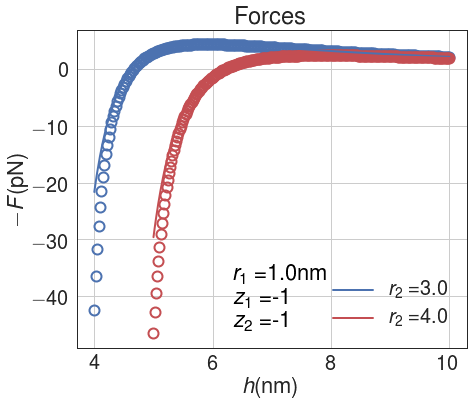

In [12]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3., 4.])#np.linspace(3, 3.1, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

fx=[plot_forces(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.set(xlabel=r'$h$(nm)', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Forces')
#plt.ylim([-100, 2])
#plt.yscale('log')
# plt.xscale('symlog')
plt.legend()
plt.show()

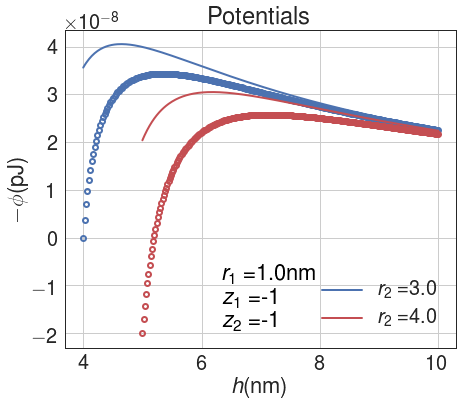

In [13]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm =np.array([3., 4.])# np.linspace(1, 10, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

phix=[plot_potentials(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.set(xlabel=r'$h$(nm)', ylabel=r'$-\phi$(pJ)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Potentials')
#plt.ylim([-100, 2])
#plt.yscale('log')
# plt.xscale('symlog')
plt.legend()
plt.show()

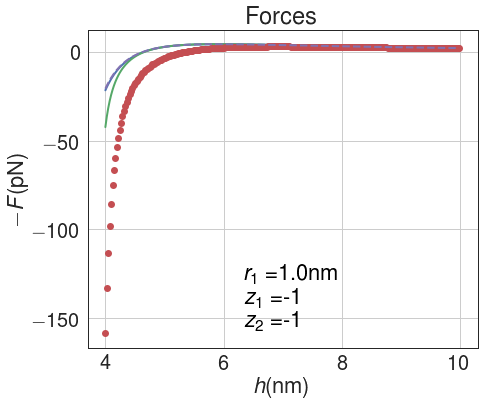

In [14]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3., 4.])#np.linspace(1, 10, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

#fx=[plot_forces(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.plot(fx[0][0]*1e9, fx[0][1])
ax.plot(fx[0][0]*1e9, fx[0][2])
ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')
ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][1])/np.diff(phix[0][0]), '--')

#force = -np.diff()
ax.set(xlabel=r'$h$(nm)', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Forces')
#plt.ylim([-100, 2])
#plt.yscale('log')
#plt.yscale('symlog')
# plt.legend()
plt.show()

In [15]:
def plot_forces2010(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25, label=r"r", lt="--", cerror=False):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 250)
    fl2010  = np.zeros_like(hl)
    force_prefactor = 1e12*q1o**2/r1o**2
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        fl2010[l] = -force_bichoutskaia2010(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e9
        

    # Plot IPA force
    force_ipa = force_ipa_fact(hl, r2, np.abs(q2), eps=eps)*force_prefactor*Ke
        #force_ipa_superposition(h_ipa, r1o, q1o, r2o, q2o, eps)*(1e12)
    fipa = ax.plot(hl*r1o*1e9, force_ipa, label=label, zorder=2)
    color = fipa[-1].get_color()
   
    plt.plot(hl*r1o*1e9, -force_prefactor*fl2010, 'o', ms=10, mfc='none', mec=color, mew=2, zorder=1)

    # Plot superposition force
    #_sf = np.linspace((r1o+r2o), rlimo, 100)
    #orce_sf = force_series(h_sf, r1o, q1o, r2o, q2o, eps, 10)*(1e12)
    #ep_sf = (h_sf-r1o-r2o)*1e9
    #f = ax.plot(h_sf*1e9, -force_sf, '--',zorder=3)    

    return hl*r1o, force_ipa, -force_prefactor*fl2010

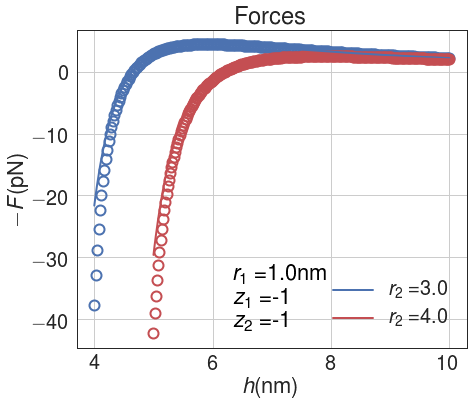

In [16]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3., 4.])#np.linspace(3, 3.1, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

fx2010=[plot_forces2010(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.set(xlabel=r'$h$(nm)', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Forces')
#plt.ylim([-100, 2])
#plt.yscale('log')
# plt.xscale('symlog')
plt.legend()
plt.show()

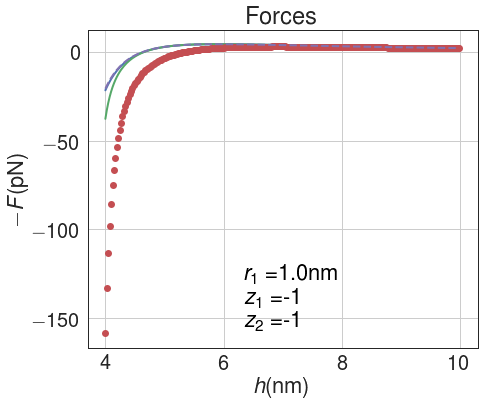

In [17]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3., 4.])#np.linspace(1, 10, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

#fx=[plot_forces(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.plot(fx2010[0][0]*1e9, fx2010[0][1])
ax.plot(fx2010[0][0]*1e9, fx2010[0][2])
ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')
ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][1])/np.diff(phix[0][0]), '--')

#force = -np.diff()
ax.set(xlabel=r'$h$(nm)', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Forces')
#plt.ylim([-100, 2])
#plt.yscale('log')
#plt.yscale('symlog')
# plt.legend()
plt.show()

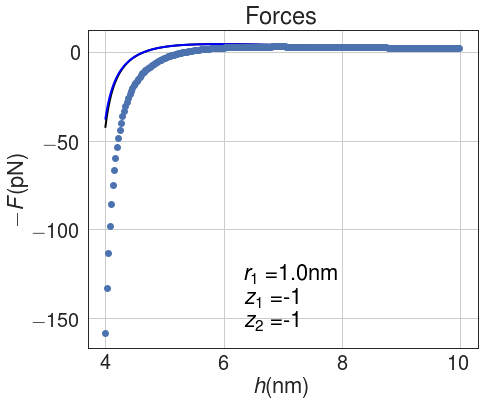

In [18]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3., 4.])#np.linspace(1, 10, 5)
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

#fx=[plot_forces(ax, r1, q1, r2, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

#ax.plot(fx[0][0]*1e9, fx[0][1])
#ax.plot(fx2010[0][0]*1e9, fx2010[0][1])
#ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][1])/np.diff(phix[0][0]), '--')

ax.plot(fx[0][0]*1e9, fx[0][2], 'k')
ax.plot(fx2010[0][0]*1e9, fx2010[0][2], 'b')
ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')


#force = -np.diff()
ax.set(xlabel=r'$h$(nm)', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Forces')
#plt.ylim([-100, 2])
#plt.yscale('log')
#plt.yscale('symlog')
# plt.legend()
plt.show()

In [45]:
def plot_potentials_paper(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25, label=r"r", lt="--", cerror=False):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    hl = np.linspace((r1+r2), rlim, 250)
    pot_b  = np.zeros_like(hl)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_b[l] = potential_bichoutskaia_mod(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e9
        

    # Plot IPA potential
    pot_ipa = potential_ipa_fact(hl, r2, np.abs(q2), eps=eps)*pot_prefactor*Ke
    pipa = ax.plot(hl*r1o*1e9, pot_ipa, label='IPA', zorder=1, lw=2, color='k')
    color = pipa[-1].get_color()

    plt.plot(hl*r1o*1e9, pot_prefactor*pot_b, '--', color='gray', zorder=2, lw=3, label='PMC')


    ## Plot IPA potential
    #h_ipa = np.linspace((r1o+r2o), rlimo, 100)
    #pot_ipa = potential_ipa_fact(hl, r2, q2, eps=eps)*potential_prefactor*Ke
    #pipa = ax.plot(hl*r1o*1e9, -pot_ipa, label='IPA', zorder=2)
    #color = pipa[-1].get_color()
    #plt.plot(hl*r1o*1e9, -potential_prefactor*pot_b, '.', ms=10, mfc='none', mec=color, mew=2, zorder=1)

    return pot_ipa, pot_prefactor*pot_b

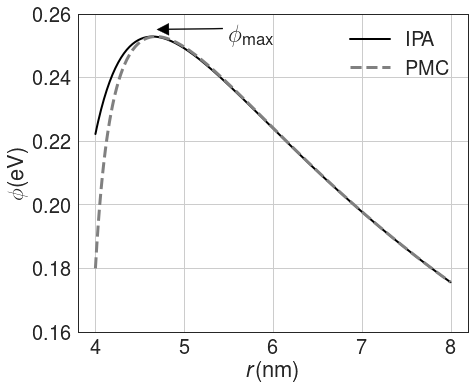

In [46]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 1.0e-9
z1 = -1
q1 = z1*const.elementary_charge
z2 = -1
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2nm = np.array([3.0])
r2m = r2nm*1e-9
rlim = np.max(r1+r2m)*2.0

phix=[plot_potentials_paper(ax, r1, q1, r2m, q2, Epsilon, rlim, label=r'$r_2=$'+str(r2nm[i]), j1max=10, j2max=10) for i, r2 in enumerate(r2m)]

ax.set(xlabel=r'$r$(nm)', ylabel=r'$\phi$(eV)')
# text = r'$r_1=$' + str(r1*1e9) + r'nm' + '\n' + '$z_1=$' + str(z1) + '\n' + '$z_2=$' + str(z2)
# left, width = .25, .5
# bottom, height = .25, .5
# right = left + width
# top = bottom + height
# ax.text(0.4*(left+right), 0.25*(bottom+top), text, horizontalalignment='left',\
#     verticalalignment='top',\
#     fontsize=22, color='black',\
#     transform=ax.transAxes)
# ax.set_title('Potentials')
plt.ylim([0.16, 0.26])
#plt.yscale('log')
# plt.xscale('symlog')
#plt.axvline(x=4.65)
#plt.axhline(y=4.65)
ax.annotate(r'$\phi_\text{max}$', xy=(4.65, 0.255), xytext=(5.5, 0.25),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            )
plt.legend()
plt.show()

# Electrostatic force

## Bichoustskaia vs Lindgren vs IPA


In [21]:
def plot_forces_BvsL(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25,
                     label=r"r", lt="--", cerror=False, f1=1.0, f2=1.0, f3=1.0):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    h = np.linspace((r1o+r2o), 130e-6, 250)
    hl = h/r1o
    fl2010  = np.zeros_like(hl)
    fl2016  = np.zeros_like(hl)
    force_prefactor = 1e12*q1o**2/r1o**2
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        fl2010[l] = -force_bichoutskaia2010(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)
        fl2016[l] = -force_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)

    sl = (hl*r1o-r1o-r2o)*1e6
#     sl = hl-r1
        

    # Plot IPA force
    force_ipa = force_ipa_fact(hl, r2, np.abs(q2), eps=eps)*force_prefactor*Ke
        #force_ipa_superposition(h_ipa, r1o, q1o, r2o, q2o, eps)*(1e12)
    #fipa = ax.plot(sl, force_ipa, 'ro', label='IPA', ms=5, mfc='none', mec=current_palette[2], mew=2, zorder=20)
   
    # plt.plot(sl, -force_prefactor*fl2010, 'o', ms=10, mfc='none', mec=color, mew=2, zorder=1)
    # plt.plot(sl, -force_prefactor*fl2016, 'x', ms=10, mfc='none', mew=2, zorder=1)

    plt.plot(sl, -force_prefactor*fl2010, label='2010', zorder=2, lw=4)
    plt.plot(sl, -force_prefactor*fl2016, label='2016', zorder=1, lw=6)
    fipa = ax.plot(sl, force_ipa, '-.', label='IPA', zorder=20, lw=3)
    
    # Plot superposition force
    #_sf = np.linspace((r1o+r2o), rlimo, 100)
    #orce_sf = force_series(h_sf, r1o, q1o, r2o, q2o, eps, 10)*(1e12)
    #ep_sf = (h_sf-r1o-r2o)*1e9
    #f = ax.plot(h_sf*1e9, -force_sf, '--',zorder=3)    

    return sl, force_ipa, -force_prefactor*fl2010, -force_prefactor*fl2016

1.65903639645


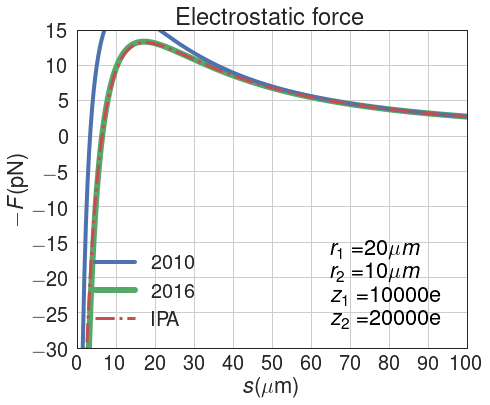

In [22]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sf, fipa, f2010, f2016 = plot_forces_BvsL(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2), 
                                          j1max=10, j2max=10)

# ax.plot(fx[0][0]*1e9, fx[0][2], 'k')
# ax.plot(fx2010[0][0]*1e9, fx2010[0][2], 'b')
# ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')


#force = -np.diff()
ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic force')
plt.ylim([-30, 15])
plt.xlim([0, 100])
plt.yticks(np.arange(-30, 20, 5.0))
plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

# Electrostatic potential

## Bichoustskaia vs IPA

In [23]:
def plot_potentials_BvsIPA(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25,
                           label=r"r", lt="--", cerror=False):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    h = np.linspace((r1o+r2o), 130e-6, 250)
    hl = h/r1o
    pot_b  = np.zeros_like(hl)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_b[l] = potential_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps)

    sl = (hl*r1o-r1o-r2o)*1e6
        

    # Plot IPA potential
    pot_ipa = potential_ipa_fact(hl, r2, np.abs(q2), eps=eps)*pot_prefactor*Ke

    plt.plot(sl, pot_prefactor*pot_b, zorder=2, lw=6, label='2010')
    pipa = ax.plot(sl, pot_ipa, '-.', color=current_palette[2], label='IPA', zorder=20, lw=3)

        
    return sl, pot_ipa, pot_prefactor*pot_b


2.3146105031
1.67544549913


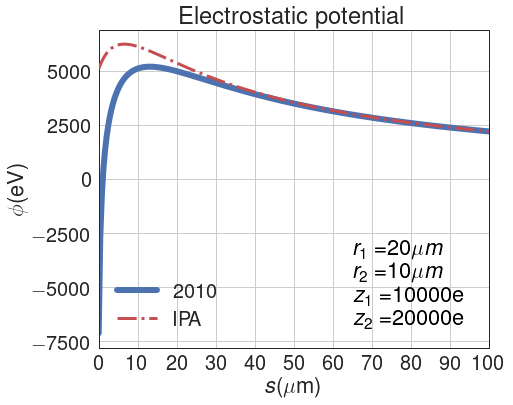

In [24]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

hp, pipa, p2010 = plot_potentials_BvsIPA(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2),
                                         j1max=20, j2max=20)

# ax.plot(fx[0][0]*1e9, fx[0][2], 'k')
# ax.plot(fx2010[0][0]*1e9, fx2010[0][2], 'b')
# ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')


#force = -np.diff()
ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$\phi$(eV)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic potential')
#plt.ylim([-30, 15])
plt.xlim([0, 100])
#plt.yticks(np.arange(-30, 20, 5.0))
plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

In [25]:
def potential_bichoutskaia_mod(r1, q1, r2, q2, h, acoeffs, eps=Epsilon, f1=1.0, f2=1.0, f3=1.0):
    ''' As defined in equation A7 of 
        Bichoutskaia, Elena et al.
        Electrostatic analysis of the interactions between charged particles of dielectric materials.
        The Journal of Chemical Physics 133, 024105 (2010).
    '''
    invK = 1.0/Ke
    lns = np.arange(len(acoeffs))
    mns = np.arange(len(acoeffs)-1)+1
    #   
    pot_coul = Ke*q1*q2/h# Coulomb term
    #
    pot_2 = 0.0
    for m in mns:# m:1 -> lns
        for l in lns:# l:0 -> lns
            numer = (acoeffs[l]*(eps-1.0)*m*np.math.factorial(l+m)*r2**(2*m+1))
            denom = ((eps+1.0)*m+1)*(np.math.factorial(l)*np.math.factorial(m))*h**(2*m+l+2)
            pot_2 += numer / denom

    pot_2 *= -q1
#     print(pot_2)
    pot_3 = 0.0
    for l in lns[1:]:# l:1 -> lns
        numer = (acoeffs[l]*acoeffs[l])*((eps+1.0)*(l)+1)#2010
        denom = (eps-1.0)*l*r1**(2*l+1)
        pot_3 += numer / denom

    pot_3 *= -invK

    return f1*pot_coul + f2*0.5*pot_2 + f3*0.5*pot_3

In [26]:
def plot_potentials_BvsIPA_mod(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25,
                              label=r"r", lt="--", cerror=False, f1=1.0, f2=1.0, f3=1.0):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    h = np.linspace((r1o+r2o), 130e-6, 250)
    hl = h/r1o
    pot_b  = np.zeros_like(hl)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_b[l] = potential_bichoutskaia_mod(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)

    sl = (hl*r1o-r1o-r2o)*1e6
        

    # Plot IPA potential
    pot_ipa = potential_ipa_fact(hl, r2, np.abs(q2), eps=eps)*pot_prefactor*Ke

    plt.plot(sl, pot_prefactor*pot_b, zorder=2, lw=6, label='mod')
    pipa = ax.plot(sl, pot_ipa, '-.', color=current_palette[2], label='IPA', zorder=20, lw=3)

        
    return sl, pot_ipa, pot_prefactor*pot_b


2.01405605218
1.60831647319


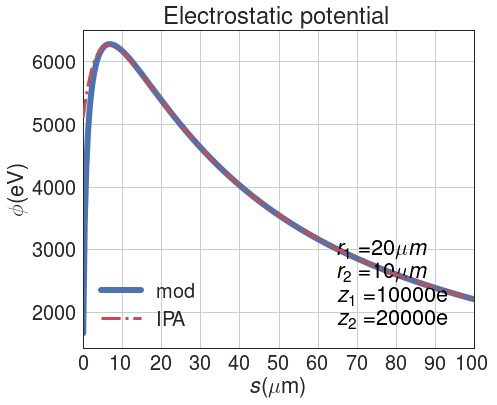

In [27]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sp, pipa, pmod = plot_potentials_BvsIPA_mod(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2),
                                            j1max=15, j2max=15, f1=1.0, f2=1.0, f3=1.0)

ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$\phi$(eV)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic potential')
#plt.ylim([-30, 15])
plt.xlim([0, 100])
#plt.yticks(np.arange(-30, 20, 5.0))
plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

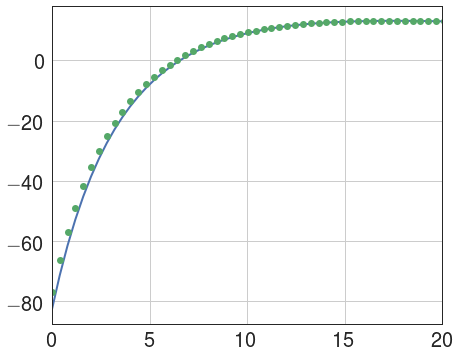

In [28]:
fig, ax = plt.subplots(figsize=(7, 5.85))

conversion_factor = 1e6*const.elementary_charge*1e12

ax.plot(sf, fipa)

#ax.plot(hf/r1, f2010, 'o')
#ax.plot(hf/r1, f2016, '--')

ax.plot(sf[:-1], -conversion_factor*np.diff(pipa)/np.diff(sf), 'o')
#plt.xlim([0, 100])
#plt.ylim([-30, 15])
plt.xlim([0, 20])
plt.show()

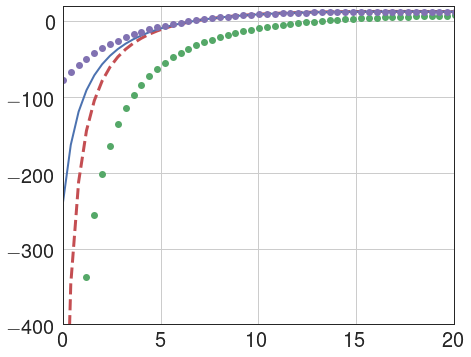

In [29]:
fig, ax = plt.subplots(figsize=(7, 5.85))

ax.plot(sf, f2016)

conversion_factor = 1e6*const.elementary_charge*1e12
ax.plot(sf[:-1], -np.diff(p2010)*conversion_factor/np.diff(sf), 'o')
ax.plot(sf[:-1], -np.diff(pmod)*conversion_factor/np.diff(sf), '--', lw=3, zorder=1)

ax.plot(sf[:-1], -conversion_factor*np.diff(pipa)/np.diff(sf), 'o')
#ax.plot(sf, fipa, '-.')
plt.ylim([-400, 20])
plt.xlim([0, 20])
plt.show()

## terms

In [30]:
def plot_forces_terms(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25,
                     label=r"r", lt="--", cerror=False, f1=1.0, f2=1.0, f3=1.0):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
#     hl = np.linspace((r1+r2), 4.5*(r1+r2), 100)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    h = np.linspace((r1o+r2o), 70e-6, 250)
    hl = h/r1o
    fl2010  = np.zeros_like(hl)
    fl2016  = np.zeros_like(hl)
    force_prefactor = 1e12*q1o**2/r1o**2
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        fl2010[l] = -force_bichoutskaia2010(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)
        fl2016[l] = -force_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)

    sl = (hl*r1o-r1o-r2o)*1e6

    plt.plot(sl, -force_prefactor*fl2010, label='2010', zorder=2, lw=4)
    plt.plot(sl, -force_prefactor*fl2016, label='2016', zorder=1, lw=6)

    return sl, -force_prefactor*fl2010, -force_prefactor*fl2016

2.01405605218
1.80890151022
1.66502839463
1.559173026


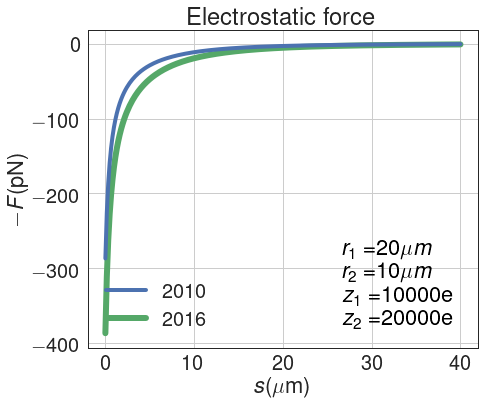

In [31]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sf, f12010, f12016 = plot_forces_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2), 
                                          j1max=15, j2max=15, f1=0.0, f2=0.0, f3=1.0)

ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic force')
#plt.ylim([-30, 15])
#plt.xlim([0, 100])
#plt.yticks(np.arange(-30, 20, 5.0))
#plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

In [32]:
def plot_potentials_terms(ax, r1o, q1o, r2o, q2o, eps, rlimo, j1max=25, j2max=25,
                              label=r"r", lt="--", cerror=False, f1=1.0, f2=0.5, f3=0.5):

    r1 = 1.0
    r2 = r2o/r1o
    q1 = np.sign(q1o)
    q2 = q2o/np.abs(q1o)
    rlim = rlimo/r1o#4.5(r1o+r2o)
    h = np.linspace((r1o+r2o), 70e-6, 250)
    hl = h/r1o
    pot_b  = np.zeros_like(hl)
    pot_bmod  = np.zeros_like(hl)
    pot_convertion = (1./const.elementary_charge)
    pot_prefactor = pot_convertion*q1o**2/r1o
    count = 0
    for l, h in enumerate(hl): 
        As, Fx, A10 = compute_Acoefficients(r1, q1, r2, q2, h, eps=eps, j1max=j1max, j2max=j2max)
        #Acs = np.linalg.solve(As, Fx)
        Acond = np.linalg.cond(As)
        if Acond > 1.5:
            count += 1
            print(Acond)
        if count > 20:
            return 0 
        Acs, res, rank, s = np.linalg.lstsq(As, Fx)
        acoeffs = np.append(A10, Acs)
        pot_bmod[l] = potential_bichoutskaia_mod(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)
        pot_b[l] = potential_bichoutskaia(r1, q1, r2, q2, h, acoeffs, eps=eps, f1=f1, f2=f2, f3=f3)

    sl = (hl*r1o-r1o-r2o)*1e6
        

    plt.plot(sl, pot_prefactor*pot_b, zorder=2, lw=6, label='2010')
    plt.plot(sl, pot_prefactor*pot_bmod, zorder=2, lw=2, label='mod')
        
    return sl, pot_prefactor*pot_b, pot_prefactor*pot_bmod


2.01405605218
1.80890151022
1.66502839463
1.559173026


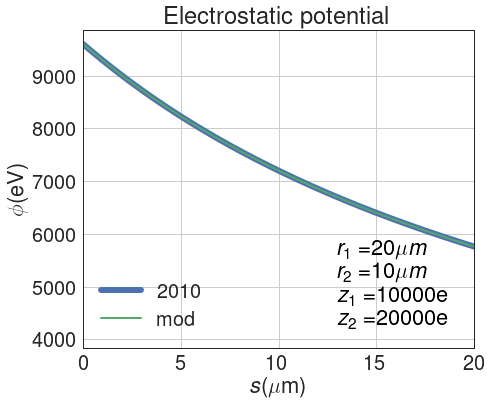

In [33]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sp, p1, pmod1 = plot_potentials_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2),
                                            j1max=15, j2max=15, f1=1.0, f2=0.0, f3=0.0)

# ax.plot(fx[0][0]*1e9, fx[0][2], 'k')
# ax.plot(fx2010[0][0]*1e9, fx2010[0][2], 'b')
# ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')


#force = -np.diff()
ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$\phi$(eV)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic potential')
#plt.ylim([-30, 15])
plt.xlim([0, 20])
#plt.yticks(np.arange(-30, 20, 5.0))
# plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

2.01405605218
1.80890151022
1.66502839463
1.559173026


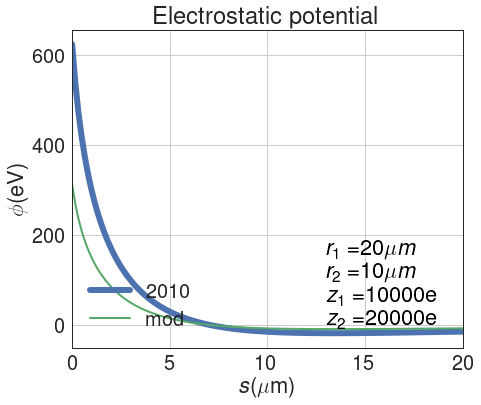

In [34]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sp, p2, p2mod = plot_potentials_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2),
                                            j1max=15, j2max=15, f1=0.0, f2=1.0, f3=0.0)

ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$\phi$(eV)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic potential')
#plt.ylim([-30, 15])
plt.xlim([0, 20])
#plt.yticks(np.arange(-30, 20, 5.0))
# plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

2.01405605218
1.80890151022
1.66502839463
1.559173026


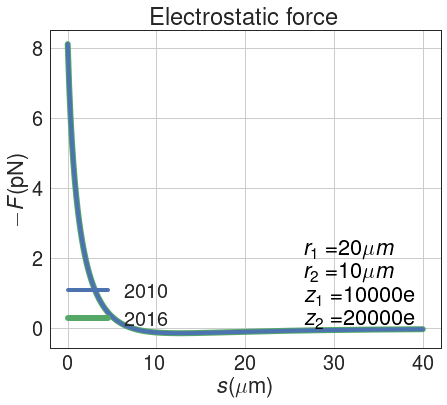

In [35]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sf, f2_2010, f2_2016 = plot_forces_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2), 
                                         j1max=15, j2max=15, f1=0.0, f2=1.0, f3=0.0)

ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic force')
#plt.ylim([-30, 15])
#plt.xlim([0, 100])
#plt.yticks(np.arange(-30, 20, 5.0))
#plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()


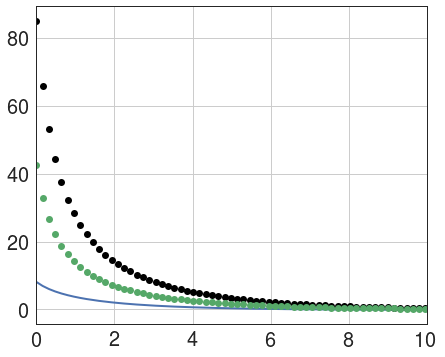

In [36]:
fig, ax = plt.subplots(figsize=(7, 5.85))

ax.plot(sf, f2_2016)

conversion_factor = 1e6*const.elementary_charge*1e12
ax.plot(sp[:-1], -np.diff(p2)*conversion_factor/np.diff(sp), 'ko')

ax.plot(sp[:-1], -np.diff(p2mod)*conversion_factor/np.diff(sp), 'o')

# ax.plot(sf[:-1], -conversion_factor*np.diff(pipa)/np.diff(sf), 'o')
# #ax.plot(sf, fipa, '-.')
# plt.ylim([-400, 20])
plt.xlim([0, 10])
plt.show()

2.01405605218
1.80890151022
1.66502839463
1.559173026


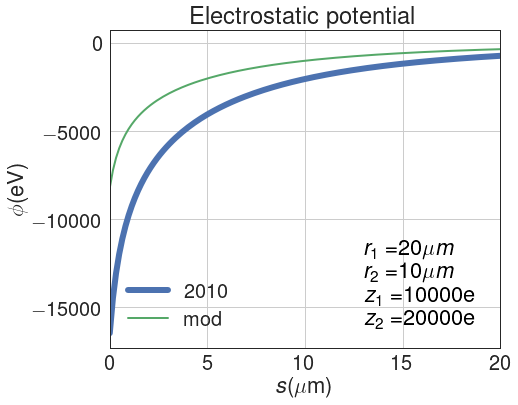

In [37]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sp, p3, p3mod = plot_potentials_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2),
                                            j1max=15, j2max=15, f1=0.0, f2=0.0, f3=1.0)

# ax.plot(fx[0][0]*1e9, fx[0][2], 'k')
# ax.plot(fx2010[0][0]*1e9, fx2010[0][2], 'b')
# ax.plot(np.array(phix[0][0]*1e9)[:-1], -np.diff(phix[0][2])/np.diff(phix[0][0]), 'o')


#force = -np.diff()
ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$\phi$(eV)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic potential')
#plt.ylim([-30, 15])
plt.xlim([0, 20])
#plt.yticks(np.arange(-30, 20, 5.0))
# plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

2.01405605218
1.80890151022
1.66502839463
1.559173026


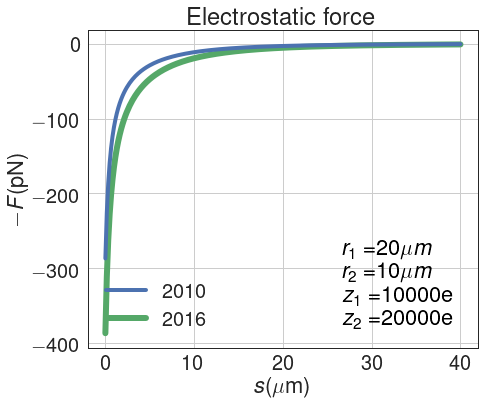

In [38]:
fig, ax = plt.subplots(figsize=(7, 5.85))
r1 = 20e-6
z1 = 10.0e3
q1 = z1*const.elementary_charge
z2 = 20.0e3
q2 = z2*const.elementary_charge
#r2nm = np.linspace(1, 100, 5)
r2 = 10e-6
rlim = 500.0e-6#np.max(r1+r2)*2.0

sf, f3_2010, f3_2016 = plot_forces_terms(ax, r1, q1, r2, q2, 20.0, rlim, label=r'$r_2=$'+str(r2), 
                                         j1max=15, j2max=15, f1=0.0, f2=0.0, f3=1.0)

ax.set(xlabel=r'$s(\mu\text{m})$', ylabel=r'$-F$(pN)')
text = r'$r_1=$' + str(int(r1*1e6)) + r'$\mu m$' + '\n'\
     + r'$r_2=$' + str(int(r2*1e6)) + r'$\mu m$' + '\n'\
     + '$z_1=$' + str(int(z1)) + 'e\n' + '$z_2=$' + str(int(z2)) + 'e'
left, width = .25, .5
bottom, height = .25, .5
right = left + width
top = bottom + height
ax.text(0.65*(left+right), 0.33*(bottom+top), text, horizontalalignment='left',\
    verticalalignment='top',\
    fontsize=22, color='black',\
    transform=ax.transAxes)
ax.set_title('Electrostatic force')
#plt.ylim([-30, 15])
#plt.xlim([0, 100])
#plt.yticks(np.arange(-30, 20, 5.0))
# plt.xticks(np.arange(0, 110, 10.0))
#plt.yscale('log')
#plt.yscale('symlog')
plt.legend(loc=3)
plt.show()

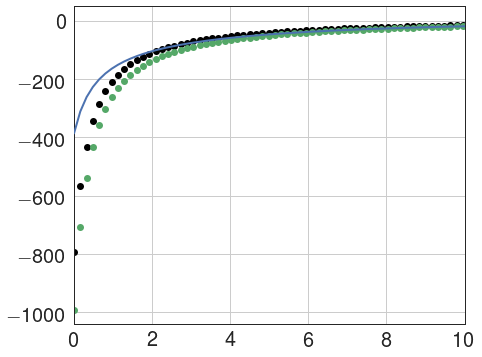

In [44]:
fig, ax = plt.subplots(figsize=(7, 5.85))

ax.plot(sf, f3_2016, zorder=10)

conversion_factor = 1e6*const.elementary_charge*1e12
ax.plot(sp[:-1], -np.diff(p3)*conversion_factor/np.diff(sp), 'ko')

ax.plot(sp[:-1], -np.diff(p3mod)*conversion_factor/np.diff(sp), 'o')

# ax.plot(sf[:-1], -conversion_factor*np.diff(pipa)/np.diff(sf), 'o')
# #ax.plot(sf, fipa, '-.')
# plt.ylim([-400, 20])
#plt.xlim([0, 20])
plt.xlim([0, 10])
plt.show()

In [41]:
f3_2016[0]/-np.diff(p3)*conversion_factor/np.diff(sp)

array([  1.93895802e-01,   2.71803353e-01,   3.56276450e-01,
         4.45480933e-01,   5.38188365e-01,   6.33603186e-01,
         7.31223010e-01,   8.30738884e-01,   9.31968022e-01,
         1.03480964e+00,   1.13921630e+00,   1.24517536e+00,
         1.35269694e+00,   1.46180614e+00,   1.57253792e+00,
         1.68493373e+00,   1.79903932e+00,   1.91490323e+00,
         2.03257589e+00,   2.15210890e+00,   2.27355466e+00,
         2.39696603e+00,   2.52239621e+00,   2.64989858e+00,
         2.77952663e+00,   2.91133394e+00,   3.04537412e+00,
         3.18170083e+00,   3.32036778e+00,   3.46142869e+00,
         3.60493736e+00,   3.75094764e+00,   3.89951344e+00,
         4.05068875e+00,   4.20452769e+00,   4.36108444e+00,
         4.52041332e+00,   4.68256879e+00,   4.84760543e+00,
         5.01557799e+00,   5.18654138e+00,   5.36055069e+00,
         5.53766119e+00,   5.71792834e+00,   5.90140783e+00,
         6.08815554e+00,   6.27822758e+00,   6.47168031e+00,
         6.66857033e+00,